# Brownian Motion Stock Predictions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import scipy
import fitter
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [3]:
aapl = yf.Ticker("AAPL")
historical_data = aapl.history(period="10y")
historical_data.index = pd.to_datetime(historical_data.index).strftime('%Y-%m-%d')
historical_data.reset_index(inplace=True)
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

historical_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2013-12-23,17.784314,17.869479,17.620249,17.849754,501306400,0.0,0.0
1,2013-12-24,17.843491,17.905799,17.722633,17.773983,167554800,0.0,0.0
2,2013-12-26,17.787448,17.831284,17.639663,17.655945,204008000,0.0,0.0
3,2013-12-27,17.653442,17.671914,17.518181,17.536654,225884400,0.0,0.0
4,2013-12-30,17.454298,17.536643,17.293361,17.362244,253629600,0.0,0.0
...,...,...,...,...,...,...,...,...
2513,2023-12-18,196.089996,196.630005,194.389999,195.889999,55751900,0.0,0.0
2514,2023-12-19,196.160004,196.949997,195.889999,196.940002,40714100,0.0,0.0
2515,2023-12-20,196.899994,197.679993,194.830002,194.830002,52242800,0.0,0.0
2516,2023-12-21,196.100006,197.080002,193.500000,194.679993,46482500,0.0,0.0


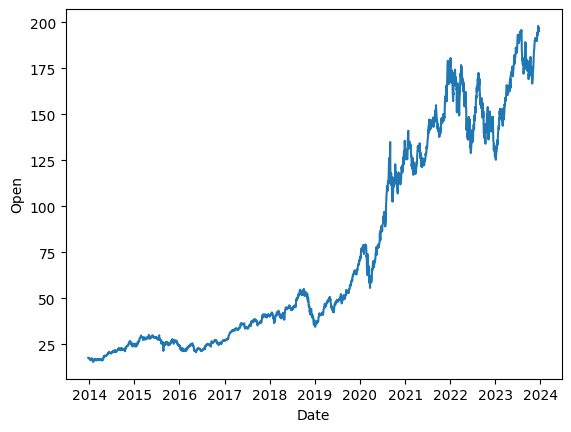

In [18]:
sns.lineplot(x='Date', y='Open', data=historical_data)
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y'))
plt.show()

In [19]:
ticker = 'AAPL'
start_date = '2013-12-19'
end_date = '2023-04-14'
pred_end_date = '2023-12-22'
prices = historical_data['Close']
test_set = prices[2700:2952]
sample = prices[0:2700]
returns = prices.pct_change().dropna()

In [20]:
pval = scipy.stats.shapiro(returns).pvalue
if pval > 0.10: # 10% significance
    print(pval)

# Brownian Motion

In [21]:
returns = prices.pct_change().dropna()
volatility = returns.std() * (252**0.5)
mu = returns.mean() * 252
sigma = volatility
sNaught = prices.iloc[-1]
T = 1
dt = 1/252
inter = int(T/dt)
np.random.seed(20) 
sims = 1000
paths = np.zeros((inter + 1, sims))
paths[0] = sNaught
for t in range(1, inter + 1):
    z_score = np.random.standard_normal(sims)
    paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma  * z_score)

In [22]:
def calc(paths, sn, mu, sigma, T):
    pts = paths[-1]
    scale = sn * np.exp(mu * T)
    probabilities = scipy.stats.lognorm.pdf(pts, s=sigma * np.sqrt(T), scale=scale)
    return probabilities

probabilities = calc(paths, sNaught, mu, sigma, T)
normalized = probabilities / probabilities.max()
indices = np.argsort(normalized)
paths = paths[:, indices]
new_probabilities = normalized[indices]
d = (paths[-1] - sNaught).mean() / sNaught

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
laplace,153.763044,265.564162,277.225808,inf,0.026792,5.294333e-02
gamma,666.109619,1019.771028,1037.263497,inf,0.077594,1.255723e-13


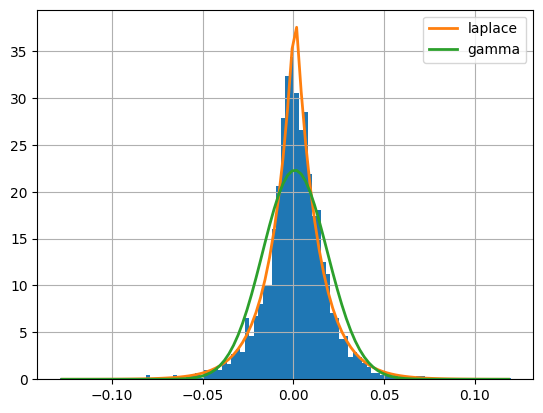

In [23]:
# Testing Different Distributions - most likely Laplace will be best fit
f = fitter.Fitter(returns, timeout = 120, distributions=['gamma', 'laplace'])
f.fit()
f.summary()

In [24]:
f.get_best(method = "bic")

{'laplace': {'loc': 0.0009405018495998174, 'scale': 0.012442479092230868}}

In [25]:
returns = sample.pct_change().dropna()
volatility = returns.std() * (252**0.5)
mu = returns.mean() * 252
sigma = volatility
sNaught = sample.iloc[-1]
T = 1
dt = 1/252
inter = int(T/dt)

np.random.seed(20) 
sims = 100
paths = np.zeros((inter + 1, sims))
paths[0] = sNaught
for t in range(1, inter + 1):
    z_score = scipy.stats.laplace.rvs(size=sims)
    paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_score)
    
probabilities = calc(paths, sNaught, mu, sigma, T)
normalized = probabilities / probabilities.max()
indices = np.argsort(normalized)
paths = paths[:, indices]
new_probabilities = normalized[indices]

Text(0, 0.5, 'Price')

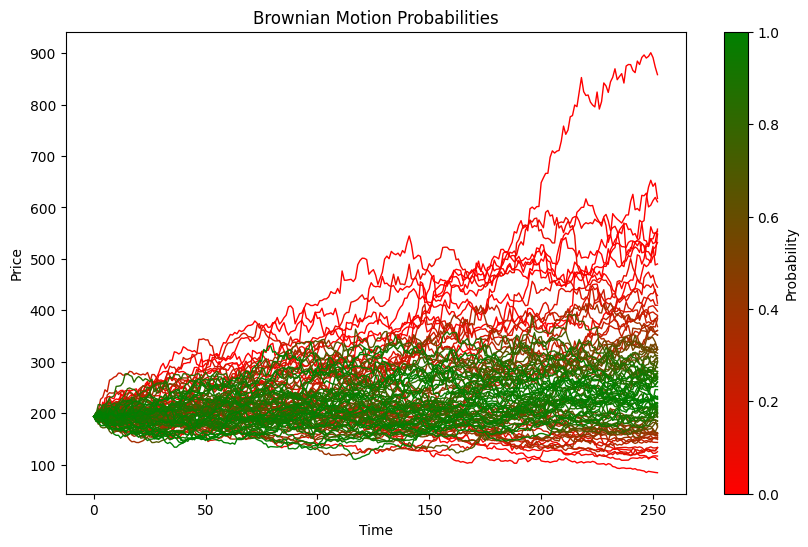

In [26]:
lsc = LinearSegmentedColormap.from_list("RedToGreen", ["red", "green"])
fig, axis = plt.subplots(figsize=(10, 6))
for i in range(sims):
    axis.plot(paths[:, i], lw=1, color=lsc(new_probabilities[i]))

axis.plot(test_set.reset_index())
sm = ScalarMappable(cmap=lsc)
prob_bar = plt.colorbar(sm, ax=axis)
prob_bar.set_label('Probability')

axis.set_title('Brownian Motion Probabilities')
axis.set_xlabel('Time')
axis.set_ylabel('Price')

## Normalizing Data
Every line in the graph above is a possible movement in price, associated with a probability. To consolidate this data as a PDF, sample every time interval, and sum the expected value of each line at that point.

## Drift 
Stocks in the long run have variable drift, which means they don't follow Geometric Brownian Motion. There are ways to account for drift, such as a random walk with a drift coefficient. Implementation coming soon.

## Confidence
As time increases, variance also increases, so we have to take into account our confidence interval at every point. The color gradient of each line at each point should reflect this confidence. Implementation coming soon.
